In [36]:
import utils
from darts import TimeSeries
import numpy as np
import pandas as pd
from darts.metrics import rmse
from darts.models import NaiveSeasonal
from darts.metrics import rmse, mape, r2_score


In [37]:
df = utils.load_data()

df.head(10)

,FFED,US_PERSONAL_SPENDING_PCE,US_CPI,US_TB_YIELD_10YRS,US_UNEMPLOYMENT_RATE
DATE,,,,,
1962-01-31,2.022727,353.200012,NaN,4.083182,5.800000
1962-02-28,2.388889,353.200012,30.040001,4.039444,5.800000
1962-03-31,2.852273,354.045441,30.062273,3.930454,5.545455
1962-04-30,2.800000,357.399994,30.139999,3.843000,5.600000
1962-05-31,2.431818,359.063629,30.186363,3.873636,5.595455
1962-06-30,2.702381,362.000000,30.224285,3.909048,5.500000
1962-07-31,2.690476,360.399994,30.225714,4.014286,5.500000
1962-08-31,2.945652,361.530426,30.214783,3.975652,5.426087
1962-09-30,2.894737,362.899994,30.248421,3.978947,5.700000


In [38]:

# Create a TimeSeries object
ts = TimeSeries.from_dataframe(df, value_cols=['US_TB_YIELD_10YRS']) #.add_holidays("US")

# Create covariates
covariates = df.drop(columns=['US_TB_YIELD_10YRS'])
covariates = TimeSeries.from_dataframe(covariates)


log_diffed = ts.map(np.log1p).diff()

In [39]:
assert len(ts.gaps()) == 0

<Axes: xlabel='DATE'>

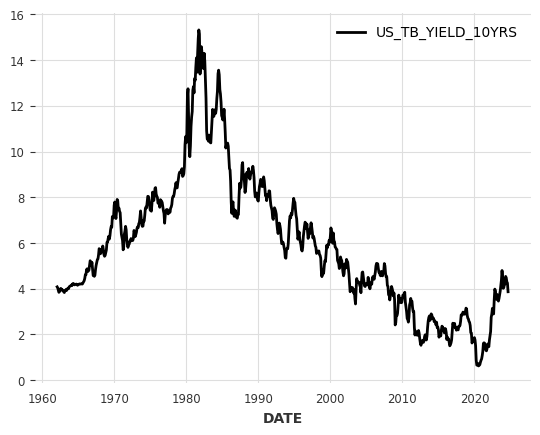

In [40]:
ts.plot()

<Axes: xlabel='DATE'>

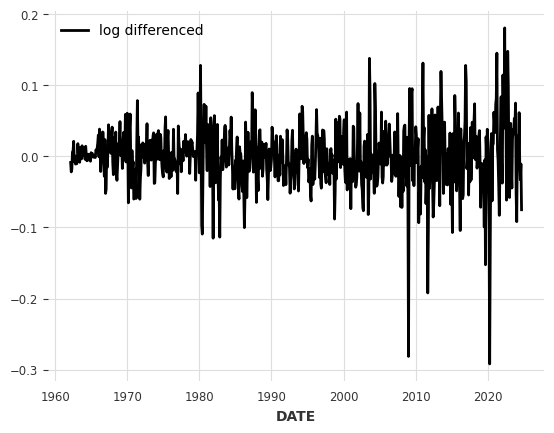

In [41]:
log_diffed["US_TB_YIELD_10YRS"].plot(label='log differenced')


# Naive Model

  0%|          | 0/104 [00:00<?, ?it/s]

rmse = 0.21
mape = 7.40%
r2 = 0.96


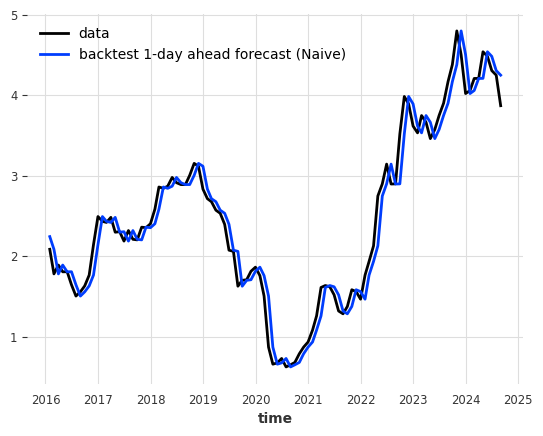

In [42]:

# Create a Naive Seasonal model
model = NaiveSeasonal(K=1)
model.fit(ts)


hfc_params = {
    "series": ts,
    "start": pd.Timestamp("2016-01-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 1,
    "verbose": True,
}
historical_fcast_theta = model.historical_forecasts(last_points_only=True, **hfc_params)

ts.drop_before(pd.Timestamp("2016-01-01")).plot(label="data")
historical_fcast_theta.plot(label="backtest 1-day ahead forecast (Naive)")
print(f"rmse = {rmse(ts, historical_fcast_theta):.2f}")
print(f"mape = {mape(ts, historical_fcast_theta):.2f}%")
print(f"r2 = {r2_score(ts, historical_fcast_theta):.2f}")



# Pytorch-based models

## RNN

In [84]:
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
    Diff
)

log_transformer = InvertibleMapper(
    fn=np.log1p, inverse_fn=np.expm1, name="log1p"
)
scaler = Scaler()
filler = MissingValuesFiller()
differentiator = Diff(dropna=True)
pipeline = Pipeline([filler, log_transformer, scaler, differentiator])


ts_scaled = pipeline.fit_transform(ts)
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))

In [85]:
from darts.models import BlockRNNModel

model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=10,
    output_chunk_length=1,
    n_epochs=100,
    random_state=0,
    model_name="block_rnn",
    log_tensorboard=True,
    save_checkpoints=True,
    force_reset=True,
    optimizer_kwargs={"lr": 0.5e-3},
    dropout=0,
    hidden_dim=20

)

model.fit(train_ts_scaled, val_series=val_ts_scaled, verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.8 K  | train
6 | fc              | Sequential       | 21     | train
-------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=20, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0, activation=ReLU, input_chunk_length=10, output_chunk_length=1, n_epochs=100, random_state=0, model_name=block_rnn, log_tensorboard=True, save_checkpoints=True, force_reset=True, optimizer_kwargs={'lr': 0.0005})

In [97]:
hfc_params = {
    "series": ts_scaled,
    "start": pd.Timestamp("2016-01-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 1,
    "verbose": True,
    "retrain": False
}

historical_fcast_block_rnn = model.historical_forecasts(last_points_only=True, **hfc_params)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

rmse = 1.61
mape = 41.30%
r2 = -1.28


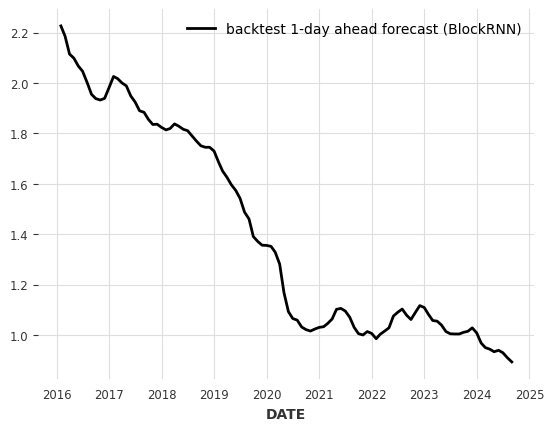

In [ ]:


historical_fcast_block_rnn = train_ts_scaled.append(historical_fcast_block_rnn)
historical_fcast_block_rnn = pipeline.inverse_transform(historical_fcast_block_rnn, partial=True)
historical_fcast_block_rnn = historical_fcast_block_rnn.drop_before(pd.Timestamp("2016-01-01"))

pipeline.inverse_transform(train_ts_scaled).plot(label="observed")
historical_fcast_block_rnn.plot(label="backtest 1-day ahead forecast (BlockRNN)")

print(f"rmse = {rmse(ts, historical_fcast_block_rnn):.2f}")
print(f"mape = {mape(ts, historical_fcast_block_rnn):.2f}%")
print(f"r2 = {r2_score(ts, historical_fcast_block_rnn):.2f}")